### BBC News: Random Forest and DistillBert

In [1]:
import os
import re
import glob
from pathlib import Path
import pickle
import pandas as pd
import numpy as np

from pymystem3 import Mystem
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Data preprocessing

In [ ]:
# Compile all files into one and create a dataset
def compile_files(path_folder, csv_file):
    with open(csv_file, 'w', encoding='utf-8') as csv_f:
        for path in glob.glob(path_folder+'/*.txt'):
            with open(path) as txt_f:
                txt = txt_f.read() + '\n'
                csv_f.write(txt)
    return csv_file


def make_dataset(folders, csv_files):
    data = []
    for i in range(len(folders)):
        for n in range(len(csv_files)):
            raw_data = compile_files(folders[i], csv_files[n])
            raw_data = pd.read_csv(csv_files[n], sep='delimiter', names=['news_data'])
            raw_data['class_label'] = Path(folders[i]).stem
        data.append(raw_data)
    return pd.concat(data, ignore_index=True)

In [ ]:
folders = ['data/business', 'data/entertainment', 'data/politics',
           'data/sport', 'data/tech']
raw_csv = ['data/raw1.csv', 'data/raw2.csv', 'data/raw3.csv',
           'data/raw4.csv', 'data/raw5.csv']

dataset = make_dataset(folders, raw_csv)
dataset.to_csv('data/bbc_news.csv', index=False)

In [ ]:
df = pd.read_csv('data/bbc_news.csv')
print(f"Shape: {df.shape}")

Shape: (12860, 2)


In [ ]:
regex = re.compile("[\w:=!\)\(\%]+")
stopword_set = set(stopwords.words('english'))
stem = Mystem()

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

def remove_stopwords(text, stopword_set=stopword_set):
    try:
        return " ".join([token for token in text.split() if not token in stopword_set])
    except:
        return ""

def lemmatize(text, stem=stem):
    try:
        return "".join(stem.lemmatize(text)).strip()
    except:
        return " "

In [ ]:
df.news_data = df.news_data.str.lower()

df.news_data = df.news_data.apply(words_only)
print('Words_only completed.')

df.news_data = df.news_data.apply(remove_stopwords)
print('Remove_stopwords completed.')

df.news_data = df.news_data.apply(lemmatize)
print('Lemmatize completed.')

Words_only completed.
Remove_stopwords completed.
Lemmatize completed.


In [ ]:
df.sample(5)

,news_data,class_label
6680,bbc steer away demonising ex downing street me...,politics
3517,regard essential celebration continental talen...,entertainment
6682,affair prompted resignation bbc chairman gavyn...,politics
8881,premiership leaders chelsea gunners endured 2 ...,sport
2385,us retail sales surge december,business


Data preparation

In [ ]:
# Encode class labels
enc = LabelEncoder()
df.class_label = enc.fit_transform(df.class_label)
labels = list(enc.classes_)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.news_data, df.class_label,
                                                    test_size=0.3, shuffle=True,
                                                    random_state=42, stratify=df.class_label)

print ("Train examples: %s" % len(y_train))
print ("Test examples: %s" % len(y_test))

Train examples: 9002
Test examples: 3858


In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))

tfidf = vectorizer.fit(X_train)
X_train_v = vectorizer.transform(X_train)
X_test_v = vectorizer.transform(X_test)

Random Forest Classifier

In [ ]:
model = RandomForestClassifier(n_estimators=100,
                               criterion='entropy',
                               random_state=42)

In [ ]:
def compute_metrics(y_test, pred):
    print("Precision: {:.2f}".format(precision_score(y_test, pred, average='macro')))
    print("Recall: {:.2f}".format(recall_score(y_test, pred, average='macro')))
    print("F1-measure: {:.2f}".format(f1_score(y_test, pred, average='macro')))
    print("Accuracy: {:.2f}".format(accuracy_score(y_test, pred)))

Precision: 0.89
Recall: 0.88
F1-measure: 0.89
Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       806
           1       0.93      0.83      0.88       632
           2       0.88      0.89      0.88       804
           3       0.83      0.97      0.89       846
           4       0.93      0.89      0.91       770

    accuracy                           0.89      3858
   macro avg       0.89      0.88      0.89      3858
weighted avg       0.89      0.89      0.89      3858



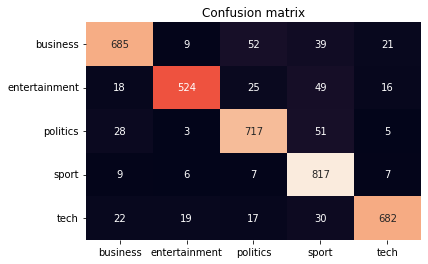

In [ ]:
model.fit(X_train_v, y_train)
pred = model.predict(X_test_v)

compute_metrics(y_test, pred)
print(classification_report(y_test, pred))

sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d",
                                  cbar=False, xticklabels=labels,
                                  yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [ ]:
# Save
def save_model(model, path_folder: str, file_name: str):
    path = Path(path_folder)
    if not os.path.isdir(path):
        os.makedirs (path)
    pickle.dump(model, open(path / file_name, "wb"))
    return None

In [ ]:
path = Path("outputs/randomForest")

# Label Encoder
save_model(enc, path, "labels_encoder.pk")

# TDidfVectorizer
save_model(tfidf, path, "tfidf.pk")
save_model(X_train_v, path, "train_features.pk")
save_model(X_test_v, path, "test_features.pk")

# RF Model
save_model(model, path, "random_forest.pk")

In [ ]:
news = "IBM to split into two as it reinvents itself. The move is an attempt to shift its\
        focus to higher-margin businesses like cloud computing and artificial intelligence.",\
        "Roger Federer: 20-time Grand Slam champion retires after Laver Cup loss.\
        The 41-year-old received a long ovation after walking off court for the final time as\
        he retired as a professional.",\
        "Liz Truss admits disruption after tax cut pledges.",\
        "Seen as the most promising next-generation solar cell, this technology, called perovskite,\
        is exactly what Japanese start-up Enecoat Technologies is trying to develop."

true_label = ['business', 'sport', 'politics', 'tech']

In [ ]:
def predict_text(text, true_labels):
    encoder = pickle.load(open(path / "labels_encoder.pk", "rb"))
    tfidf_vec = pickle.load(open(path / "tfidf.pk", "rb"))
    model_load = pickle.load(open(path / "random_forest.pk", "rb"))
    labels = list(encoder.classes_)
    y_true = encoder.transform(true_labels)
    text_vec = tfidf_vec.transform(text)
    pred = model.predict(text_vec)
    
    print("Accuracy: {:.2f}".format(accuracy_score(y_true, pred)))
    print("True label: ", [labels[y_true[i]] for i, _ in enumerate(true_labels)])
    print("Predicted label: ", [labels[pred[i]] for i, _ in enumerate(pred)])

In [ ]:
predict_text(news, true_label)

Accuracy: 0.75
True label:  ['business', 'sport', 'politics', 'tech']
Predicted label:  ['sport', 'sport', 'politics', 'tech']


Fine-Tuning: DistillBert

In [ ]:
# !pip install datasets
# !pip install transformers

In [3]:
import torch
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
dataset = load_dataset("csv", data_files="data/bbc_news.csv")

In [7]:
# casting class labels to integers
labels_list = dataset['train'].unique('class_label')
id2label = {n: i for n, i in enumerate(labels_list)}
label2id = {i: n for n, i in enumerate(labels_list)}

def cast_label(row):
    val = [str(k) for k, v in id2label.items() if v == row['class_label']]
    return {'labels': int("".join(val))}

dataset = dataset.map(cast_label)
dataset = dataset.remove_columns("class_label")

  0%|          | 0/12860 [00:00<?, ?ex/s]

In [8]:
train_test_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
test_valid = train_test_dataset["test"].train_test_split(test_size=0.6, seed=42)

# Gather to have a single DatasetDict
split_dataset = DatasetDict({'train': train_test_dataset['train'],
                             'test': test_valid['test'],
                             'valid': test_valid['train']})

print('Shapes:')
print('Train: {}'.format(split_dataset['train'].shape))
print('Validation:{}'.format(split_dataset['valid'].shape))
print('Test:{}'.format(split_dataset['test'].shape))

Shapes:
Train: (10288, 2)
Validation:(1028, 2)
Test:(1544, 2)


In [9]:
data_sample = split_dataset['train'].shuffle().select(range(1000))
data_sample[:3]

{'news_data': ['Amnesty International UK also questioned whether the decisions had been based on "torture evidence" obtained at Guantanamo Bay. "Furthermore, we believe there should be an investigation into the role played by the UK in the detention of UK residents and nationals and possibly many others at Guantanamo Bay," said director Kate Allen. The men\'s solicitor, Louise Christian, has raised questions about whether the evidence was gathered through torture. But the Pentagon told BBC News US policy "condemns and prohibits" torture and said there was no evidence that any British detainee was tortured or abused. Mr Abbasi, 23, from Croydon, south London, was taken to Guantanamo Bay after being captured in Afghanistan in 2001. Mr Mubanga, 29, from north London, was originally detained in Zambia.',
  'The character generator is very detailed and a few minutes of tweaking and adjusting will create a unique personality to unleash on the game.',
  'Bloglines has become popular because i

In [ ]:
# Tokenization
checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(checkpoint)

train_d = split_dataset['train'].map(lambda e: tokenizer(e['news_data'], truncation=True), batched=True)
val_d = split_dataset['valid'].map(lambda e: tokenizer(e['news_data'], truncation=True), batched=True)
test_d = split_dataset['test'].map(lambda e: tokenizer(e['news_data'], truncation=True), batched=True)

In [11]:
# Eliminate the news_data column and adjust the type
train_d.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_d.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_d.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print(train_d[0])

{'labels': tensor(4), 'input_ids': tensor([  101,  2028,  2154,  2101,  2139, 10093, 13910,  2527, 10354,  1010,
         1037,  3679,  7598,  3780,  1010,  2150,  2739,  2006,  2049,  2219,
         2043,  2009,  2405,  1037,  3861,  2579,  2007,  1037,  4684,  3042,
         1997,  2720,  3158, 26603,  1005,  1055,  2303,  5312,  2044,  2002,
         2001,  2730,  1012,  1000,  2023,  3861,  2001,  1996,  2466,  1000,
         1010,  2056,  2139, 10093, 13910,  2527, 10354,  1005,  1055,  3746,
         3559,  1010,  2848,  8040,  6806,  5643,  2078,  1012,  2060,  6115,
         1997,  2107,  3861,  3042,  5198, 24740,  2739,  2824,  1010,  2421,
         1024,   102]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}


In [12]:
# Dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(train_d, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_d, batch_size=batch_size, collate_fn=data_collator)
test_dataloader = DataLoader(test_d, batch_size=batch_size, collate_fn=data_collator)

In [13]:
for step, batch in enumerate(test_dataloader):
    print(batch['input_ids'].shape)
    if step > 3:
        break

# for batch in train_dataloader:
#    break
# {k: v.shape for k, v in batch.items()}

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.Size([32, 359])
torch.Size([32, 300])
torch.Size([32, 201])
torch.Size([32, 349])
torch.Size([32, 291])


In [14]:
model = DistilBertForSequenceClassification.from_pretrained(checkpoint,
                       id2label=id2label, label2id=label2id).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [15]:
training_args = TrainingArguments(
    output_dir='outputs/output',
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='outputs/logs',
    logging_steps=100,
    evaluation_strategy= 'steps',
    eval_steps=100
)

In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    Precision, Recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': Precision,
        'Recall': Recall
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_d,
    eval_dataset=val_d,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [17]:
results = trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: news_data. If news_data are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 10288
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 966


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.965600,0.256429,0.928988,0.930827,0.933214,0.930905
200,0.229400,0.180914,0.945525,0.945993,0.947167,0.945878
300,0.217300,0.123315,0.959144,0.958755,0.959701,0.958161
400,0.111800,0.109740,0.964981,0.964768,0.965282,0.964677
500,0.083600,0.137250,0.967899,0.967470,0.967367,0.967890
600,0.089200,0.116259,0.969844,0.969828,0.970470,0.969697
700,0.070000,0.108492,0.973735,0.973885,0.974673,0.973254
800,0.028700,0.120482,0.972763,0.972628,0.972787,0.972652
900,0.032700,0.108853,0.974708,0.974745,0.975264,0.974429


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: news_data. If news_data are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1028
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: news_data. If news_data are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1028
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: news_data. If news_data are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Eval

In [18]:
evaluatn = [trainer.evaluate(eval_dataset=data) for data in [train_d, val_d, test_d]]
pd.DataFrame(evaluatn, index=["train","val","test"]).iloc[:, :5]

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: news_data. If news_data are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10288
  Batch size = 32


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: news_data. If news_data are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1028
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: news_data. If news_data are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1544
  Batch size = 32


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.014283,0.996890,0.996809,0.996766,0.996853
val,0.109789,0.970817,0.970740,0.971255,0.970433
test,0.167660,0.957254,0.957065,0.957663,0.956975


In [19]:
model_path = "outputs/distillBert"
tokenizer.save_pretrained(model_path)
trainer.save_model(model_path)

tokenizer config file saved in outputs/distillBert/tokenizer_config.json
Special tokens file saved in outputs/distillBert/special_tokens_map.json
Saving model checkpoint to outputs/distillBert
Configuration saved in outputs/distillBert/config.json
Model weights saved in outputs/distillBert/pytorch_model.bin


In [20]:
tokenizer_load= DistilBertTokenizerFast.from_pretrained(model_path)
model_load = DistilBertForSequenceClassification.from_pretrained(model_path).to(device)

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file outputs/distillBert/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "business",
    "1": "entertainment",
    "2": "politics",
    "3": "sport",
    "4": "tech"
  },
  "initializer_range": 0.02,
  "label2id": {
    "business": 0,
    "entertainment": 1,
    "politics": 2,
    "sport": 3,
    "tech": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": 

In [21]:
news = ["IBM to split into two as it reinvents itself. The move is an attempt to shift its\
        focus to higher-margin businesses like cloud computing and artificial intelligence.",\
        "Roger Federer: 20-time Grand Slam champion retires after Laver Cup loss.\
        The 41-year-old received a long ovation after walking off court for the final time as\
        he retired as a professional.",\
        "Liz Truss admits disruption after tax cut pledges.",\
        "Seen as the most promising next-generation solar cell, this technology, called perovskite,\
        is exactly what Japanese start-up Enecoat Technologies is trying to develop."]

true_label = ['business', 'sport', 'politics', 'tech']

In [22]:
def get_predict(text, labels):
    inputs = tokenizer_load(text, padding=True, truncation=True, return_tensors="pt").to(device)
    outputs = model_load(inputs["input_ids"].to(device), inputs["attention_mask"].to(device))
    probs = outputs[0].softmax(1)
    pred_idx = [prob.argmax().item() for prob in probs]
    pred = [model_load.config.id2label[idx] for idx in pred_idx]
    
    print("Accuracy: ", accuracy_score(labels, pred))
    print("True labels: ", labels)
    print("Predicted labels: ", pred)

In [23]:
get_predict(news, true_label)

Accuracy:  0.75
True labels:  ['business', 'sport', 'politics', 'tech']
Predicted labels:  ['tech', 'sport', 'politics', 'tech']


The DistillBert shows higher metrics scores than the Random Forest Classifier.<br>
On few, four unseen, pieces of news both models missclassified 1 (out of 4) category.